In [1]:
from pyspark.sql import functions as F
from pyspark.sql.functions import *
import pyspark.pandas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from pyspark.sql import SparkSession

# Create a spark session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/10/10 00:34:52 WARN Utils: Your hostname, LAPTOP-UQ7BDL4T resolves to a loopback address: 127.0.1.1; using 172.22.156.140 instead (on interface eth0)
22/10/10 00:34:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/10 00:34:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 1.Read the data in and check the presence of null value

In [3]:
# function used to check the presence of null values.
def check_null_value(dataframe):
    """ Accept a dataframe, check the presence of null values.
    """
    for columns in dataframe.columns:
        print('Number of null value in', columns, ':', dataframe.where(F.col(columns).isNull()).count())
    return

In [4]:
consumer_id = spark.read.parquet('../data/tables/consumer_user_details.parquet')
check_null_value(consumer_id)

Number of null value in user_id : 0
Number of null value in consumer_id : 0


In [5]:
# Use pandas read consumer csv
raw_consumer_df = spark.read.option("header",True).csv('../data/tables/tbl_consumer.csv')
check_null_value(raw_consumer_df)

Number of null value in name : 0
Number of null value in address : 0
Number of null value in state : 0
Number of null value in postcode : 0
Number of null value in gender : 0
Number of null value in consumer_id : 0


In [6]:
raw_merchant_df = spark.read.parquet('../data/tables/tbl_merchants.parquet').withColumnRenamed('name','merchant_name')
check_null_value(raw_merchant_df)

Number of null value in merchant_name : 0
Number of null value in tags : 0
Number of null value in merchant_abn : 0


In [7]:
path_list = []
period1 = pd.date_range('2021-2-28','2021-08-27', freq='D').strftime("%Y-%m-%d").tolist()
period2 = pd.date_range('2021-8-28','2022-02-27', freq='D').strftime("%Y-%m-%d").tolist()
period3 = pd.date_range('2022-2-28','2022-08-28', freq='D').strftime("%Y-%m-%d").tolist()
path_prefix1 = '../data/tables/transactions_20210228_20210827_snapshot/order_datetime='
path_prefix2 = '../data/tables/transactions_20210828_20220227_snapshot/order_datetime='
path_prefix3 = '../data/tables/transactions_20220228_20220828_snapshot/order_datetime='
for date in period1:
    path_list.append(path_prefix1 + date)
for date in period2:
    path_list.append(path_prefix2 + date)
for date in period3:
    path_list.append(path_prefix3 + date)

raw_transactions_df = spark.read.parquet(*path_list)

check_null_value(raw_transactions_df)

Number of null value in user_id : 0


Number of null value in merchant_abn : 0


Number of null value in dollar_value : 0


Number of null value in order_id : 0


#### No null value is found in the raw datasets.

# 2. Data aggregation

First, we aggregate the given consumer, merchant and transactions data, drop the irrelevant features for the ranking system such as consumers' id and name, transactions' order id and merchants' abn.

In [8]:
consumer_df =  consumer_id.join(raw_consumer_df, consumer_id.consumer_id == raw_consumer_df.consumer_id, 'inner')\
                            .withColumnRenamed('name','consumer_name')\
                            .withColumnRenamed('address','consumer_address')

In [9]:
raw_merchant_df

merchant_name,tags,merchant_abn
Felis Limited,"((furniture, home...",10023283211
Arcu Ac Orci Corp...,"([cable, satellit...",10142254217
Nunc Sed Company,"([jewelry, watch,...",10165489824
Ultricies Digniss...,"([wAtch, clock, a...",10187291046
Enim Condimentum PC,([music shops - m...,10192359162
Fusce Company,"[(gift, card, nov...",10206519221
Aliquam Enim Inco...,"[(computers, comP...",10255988167
Ipsum Primis Ltd,"[[watch, clock, a...",10264435225
Pede Ultrices Ind...,([computer progra...,10279061213
Nunc Inc.,"[(furniture, home...",10323485998


Get the take rate of each merchant.

In [10]:
merchant_df = raw_merchant_df.withColumn('tags_string1', split(raw_merchant_df['tags'], ':'))\
                             .withColumn('tags_string2', split(raw_merchant_df['tags'], '\)'))\
                             .withColumn('tags_string3', element_at(col('tags_string2'), 1))\
                             .withColumn('rate_string', element_at(col('tags_string1'), -1))\
                             .withColumn('rate_substring', substring('rate_string', 1, 5))\
                             .withColumn('take_rate', col('rate_substring').cast('double'))\
                             .drop('rate_string', 'rate_substring','tags_string1', 'tags_string2')

In [11]:
merchant_df = merchant_df.withColumn('tags_string4', split(merchant_df['tags_string3'], ']'))\
                         .withColumn('type_string1', element_at(col('tags_string4'), 1))\
                         .withColumn('type_string2', substring('type_string1', 3, 100))\
                         .withColumn('type1', lower(col('type_string2')))\
                         .withColumn('type', regexp_replace(col('type1'), '  ', ' '))\
                         .drop('tags', 'tags_string3', 'tags_string4', 'type_string', 'type_string1','type_string2','type1')

In [12]:
merchant_df

merchant_name,merchant_abn,take_rate,type
Felis Limited,10023283211,0.18,"furniture, home f..."
Arcu Ac Orci Corp...,10142254217,4.22,"cable, satellite,..."
Nunc Sed Company,10165489824,4.4,"jewelry, watch, c..."
Ultricies Digniss...,10187291046,3.29,"watch, clock, and..."
Enim Condimentum PC,10192359162,6.33,music shops - mus...
Fusce Company,10206519221,6.34,"gift, card, novel..."
Aliquam Enim Inco...,10255988167,4.32,"computers, comput..."
Ipsum Primis Ltd,10264435225,2.39,"watch, clock, and..."
Pede Ultrices Ind...,10279061213,5.71,computer programm...
Nunc Inc.,10323485998,6.61,"furniture, home f..."


In [13]:
merchant_type = merchant_df.groupBy('type')\
                  .agg(F.count('type').alias('count'), )\
                  .toPandas()
merchant_type['index'] = merchant_type.index+1

In [14]:
merchant_type

,type,count,index
0,"opticians, optical goods, and eyeglasses",151,1
1,"watch, clock, and jewelry repair shops",170,2
2,"computer programming , data processing, and in...",191,3
3,"digital goods: books, movies, music",195,4
4,"books, periodicals, and newspapers",164,5
5,"florists supplies, nursery stock, and flowers",180,6
6,art dealers and galleries,112,7
7,"antique shops - sales, repairs, and restoratio...",129,8
8,"gift, card, novelty, and souvenir shops",182,9
9,"equipment, tool, furniture, and appliance rent...",134,10


Text(0.5, 1.0, 'the number of merchants for each type')

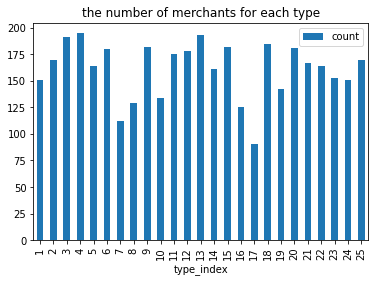

In [15]:
merchant_type.plot.bar(x='index', y='count')
plt.xlabel('type_index')
plt.title('the number of merchants for each type')

In [16]:
transactions_df = raw_transactions_df.join(merchant_df, raw_transactions_df.merchant_abn == merchant_df.merchant_abn, 'inner')\
                           .join(consumer_df, raw_transactions_df.user_id == consumer_df.user_id, 'inner')\
                           .drop('consumer_id', 'consumer_name')\
                           .drop(consumer_df.user_id)\
                           .drop(raw_transactions_df.merchant_abn)

In [17]:
raw_transactions_df.count(), transactions_df.count()

(12561377, 12047317)

Since some merchant abns from the transaction data do not match with any merchant from the merchant, we should remove them by inner join with the merchant dataset. About  5% of data are eliminated.

We compute the total income, the number of transactions, the mean transaction amount and the profit for each merchant for the preliminary analysis.

In [18]:
merchant_detail = transactions_df.groupBy('merchant_abn', 'merchant_name', 'type', 'take_rate')\
                  .agg(
                       F.round(F.sum('dollar_value'),2).alias('total_income'),
                       F.count('merchant_name').alias('total_transactions'), )\
                  .withColumn('mean_transaction_amount',  F.round(F.col('total_income')/F.col('total_transactions')))\
                  .withColumn('BNPL_monthly_profit',  F.round(F.col('total_income')*F.col('take_rate')/100/18))\
                  .orderBy('BNPL_monthly_profit', ascending = False)

In [19]:
merchant_detail

merchant_abn,merchant_name,type,take_rate,total_income,total_transactions,mean_transaction_amount,BNPL_monthly_profit
79827781481,Amet Risus Inc.,"furniture, home f...",6.82,8657277.1,4251,2037.0,32801.0
48534649627,Dignissim Maecena...,"opticians, optica...",6.64,8316735.67,58685,142.0,30680.0
32361057556,Orci In Consequat...,"gift, card, novel...",6.61,8339994.52,75853,110.0,30626.0
86578477987,Leo In Consulting,"watch, clock, and...",6.43,8443178.7,241336,35.0,30161.0
38700038932,Etiam Bibendum In...,tent and awning s...,6.31,8482176.66,6341,1338.0,29735.0
45629217853,Lacus Consulting,"gift, card, novel...",6.98,7436925.45,201830,37.0,28839.0
96680767841,Ornare Limited,motor vehicle sup...,5.91,8679874.17,27541,315.0,28499.0
21439773999,Mauris Non Institute,"cable, satellite,...",6.1,8337853.96,106724,78.0,28256.0
63123845164,Odio Phasellus In...,artist supply and...,6.59,7570160.92,10075,751.0,27715.0
64403598239,Lobortis Ultrices...,music shops - mus...,6.31,7842635.61,100394,78.0,27493.0


In [20]:
merchant_detail.count(), merchant_df.count()

(4026, 4026)

In [21]:
merchant_detail.write.mode('overwrite').parquet('../data/curated/merchant_detail.parquet')

In [ ]:
transactions_df.write.mode('overwrite').parquet('../data/curated/transactions_detail.parquet')

# 3. Preliminarily check distribution of data

In [ ]:
bins, counts = merchant_detail.select('BNPL_monthly_profit').rdd.flatMap(lambda x: x).histogram(200)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.ylabel('Frequency')
plt.xlabel('monthly_profit (dollar)')
plt.title('Histogram graph of monthly profit')
plt.show()

In [ ]:
bins, counts = merchant_detail.select('total_transactions').rdd.flatMap(lambda x: x).histogram(200)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.ylabel('Frequency')
plt.xlabel('transaction frequency')
plt.title('Histogram graph of total transactions')
plt.show()

In [ ]:
bins, counts = merchant_detail.select('mean_transaction_amount').rdd.flatMap(lambda x: x).histogram(200)
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.ylabel('Frequency')
plt.xlabel('mean transaction (dollar)')
plt.title('Histogram graph of mean transaction amount')
plt.show()

There are some extremely large values, outliers elimination and data transformation may be needed.